<a href="https://colab.research.google.com/github/DavoodSZ1993/RL/blob/main/05_MC_Control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
import numpy as np
import gym

env = gym.make('Blackjack-v0')

In [59]:
state_space_size = (33, 12, 2)
policy = np.zeros(state_space_size, dtype=int)

In [60]:
def observation_clean(observation):
  return (observation[0], observation[1], int(observation[2]))

### Side Note: Binomial Probability Distribution:

* $X \sim Binomial(n,p)$ (where $0\le p\le1$): the number of heads in $n$ independent flips of a coin with heads probability $p$.

$$
p(x) = \begin{bmatrix} n \\ x\end{bmatrix}p^x(1-p)^{n-x}
$$

* **Probability Mass Functions (PMFs)**:
When a random variable $X$ takes on a finite set of possible values (i.e., $X$ is a discrete random variable), a simpler way to represent the probability measure associated with a random variable is to directly specifiy the probability of each value that the random variable can assume. In particular, a _probability mass function (PMF)_ is a function $p_x: \Omega →R$ such that:

$$
p_X(x)=P(X=x)
$$

In [70]:
def run_episode_exploring_start(policy, env=env):
  steps = []
  observation = observation_clean(env.reset())
  done = False
  steps.append(((None, None) + (observation, 0))) # State, Action, Next State, Reward
  start = True

  while not done:
    if start:
      action = np.random.binomial(n=1, p=0.5)  # returns a sample (n=1) either zero or one based on binominal distribution(p=0.5)
      start = False
    else:
      action = policy[observation]

    observation_action = (observation, action)
    observation, reward, done, info = env.step(action)
    observation = observation_clean(observation)
    steps.append(observation_action + (observation, int(reward)))
  return steps

In [71]:
size = list(state_space_size) + [2]
Q = np.zeros(size)
Q.shape

(33, 12, 2, 2)

### Side Note: `defaultdict` in Python
Defaultdict is a container like dictionaries present in the module collections. Defaultdict is a sub-class of the dictionary class that returns a dictionary-like object. The functionality of both dictionaries and defaultdict are almost same except for the fact that defaultdict never raises a KeyError. It provides a default value for the key that does not exists.

In [73]:
from collections import defaultdict
returns = defaultdict(list)
print(returns)

defaultdict(<class 'list'>, {})


In [77]:
nb_of_episodes = 500000
gamma = 0.99


# Greedy Algorithm
def monte_carlo_optimal_policy(nb_of_episodes,
                               policy = np.random.binomial(n=1, p=0.5, size=state_space_size),
                               run_episode = run_episode_exploring_start):
  for i in range(nb_of_episodes):
    # (a) generate an episode uring exploring starts and pi (policy)
    observations_reward = run_episode(policy)

    G = 0. # Current return
    # use a map for the first visit condition:
    o_a = {} # map from states to (action, return)-Tuple
    for o0, a, o, r in reversed(observations_reward):
      G = r + gamma * G   # Monte-Carlo method, starts from last state and comes to the first state of the episode
      o_a[o0] = a, G      # Dictionary: Key = state, Value = (action, state value)

    # (b) for each pair (s,a) appearing in the episode
    for o, (a, G) in o_a.items():
      if o is not None:
        returns[(o, a)].append(G)
        re_mean = np.array(returns[(o, a)]).mean()  # Experimental mean for each state
        Q[(o) + (a,)] = re_mean                     # reward regarded to each state-action pair

        # for each s in the episode: optimize policy
        policy[o] = np.argmax(Q[o])   # argmax over all actions, picks the action with highest value
  return policy

policy = monte_carlo_optimal_policy(nb_of_episodes)
policy.shape

(33, 12, 2)

In [78]:
Q[5, 8, 0, 1]

-0.14584235657323946

In [79]:
policy[5, 5, 0]

1

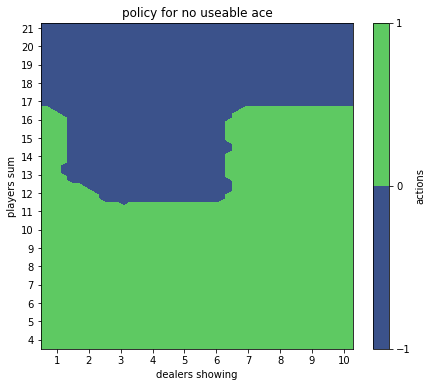

In [80]:
import scipy.ndimage               # This package contains various functions for multidimensional image processing
import matplotlib.pyplot as plt
%matplotlib inline


def plot_policy_useable_ace(policy):
  B = np.arange(4-0.5, 22-0.5, 0.2)
  A = np.arange(1-0.5, 11-0.5, 0.2)
  A, B = np.meshgrid(A, B)

  Po = scipy.ndimage.zoom(policy[4:22, 1:11, 0], 5)   # Zoom an array for better resolution in illustration
  levels = range(-1, 2)
  plt.figure(figsize=(7,6))
  CS = plt.contourf(A, B, Po, levels)
  cbar = plt.colorbar(CS)
  cbar.ax.set_ylabel('actions')
  #plt.clabel(CS, inline=1, fontsize=10)
  plt.title('policy for no useable ace')
  plt.xlabel("dealers showing")
  plt.ylabel("players sum")
  _ = plt.xticks(range(1,11))
  _ = plt.yticks(range(4, 22))

plot_policy_useable_ace(policy)

((90, 50), (18, 10))